# World CO2 Emissions Forecasting
## Fitting a LSTM Model (Recurrent Neural Network)
[*Cristian Castro Álvarez*](https://github.com/cristian-castro-a)

**Goal**: 
- To fit a LSTM Model to the World CO2 Emissions


**Data:**
- The data comes from [Our World in Data](https://github.com/owid/co2-data)
- Column 'CO2' of the dataframe indicates the Tonnes of CO2 emmitted into the atmosphere.
- The dataset includes yearly data from 1750 to 2020, with a total of 271 data points.

In [1]:
# Libraries
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
import os

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

# The World CO2 Emissions Data

In [2]:
df = pd.read_csv('../Data/owid-co2-data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [3]:
# Aggregate the data on a yearly basis (the entire world as one entity, I don't care about the emissions of individual countries)
df = df.groupby(by=['year']).sum().reset_index()[['year','co2']]
df.insert(loc = 1, column = 'month', value = 12)
df.insert(loc = 2, column = 'day', value = 31)
values = pd.to_datetime(df[['year','month','day']])
df.insert(loc = 0, column = 'date', value = values)
df.drop(['year','month','day'], axis = 1, inplace = True)
df.head()

,date,co2
0,1750-12-31,46.755
1,1751-12-31,46.755
2,1752-12-31,46.770
3,1753-12-31,46.770
4,1754-12-31,46.790


In [4]:
# To work with tonnes of CO2 it is necessary a conversion factor of 3.664
df['co2'] = df['co2']/3.664
df.tail().round(1)

,date,co2
266,2016-12-31,34035.4
267,2017-12-31,34471.8
268,2018-12-31,35058.0
269,2019-12-31,35049.9
270,2020-12-31,33185.8


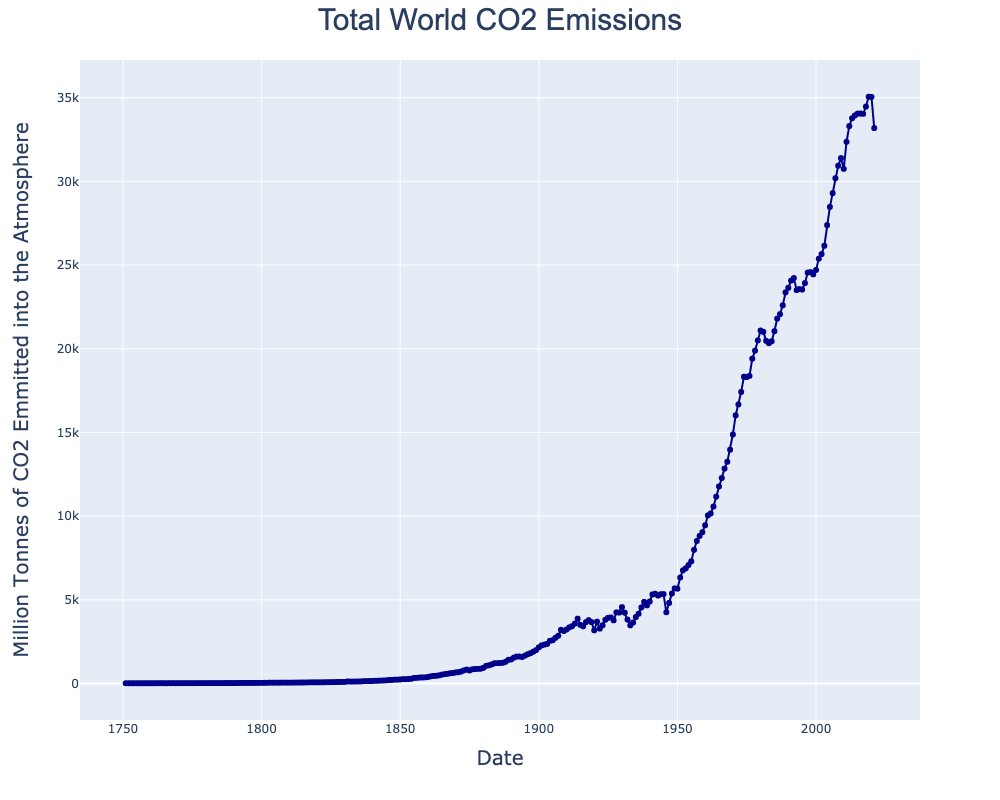

In [5]:
# Visualizing the world emissions per year
fig = px.line(df, 
                x = 'date', 
                y = 'co2', 
                markers = True, 
                height = 800, 
                width = 1000)

fig.update_layout(title = dict(
        text = 'Total World CO2 Emissions',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
    )

fig.update_traces(line_color = 'darkblue')

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.show('png')

# Preprocessing the Data for a LSTM Model

- We are going to input multiple sequences of data to train the LSTM Recurrent Neural Network
- These sequences must be the same length, throughout the training period
- Therefore we will create a windowing function, that will create sequences of fixed length to be used as inputs for our model

## Windowing Function

In [6]:
def df_to_inputs(df, window_size = 5):
    # Input: dataframe with the time series and window size
    # Windows size refers to the number of points in the series with which the model will be trained
    # Output: X, y for training
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        X.append([[a] for a in df_as_np[i:i+5]])
        y.append(df_as_np[i+5])
    return np.array(X), np.array(y)

In [7]:
# Getting the windows
WINDOW_SIZE = 5
X, y = df_to_inputs(df['co2'], WINDOW_SIZE)

In [8]:
X.shape, y.shape

((266, 5, 1), (266,))

In [9]:
X[1:3]

array([[[12.7606441 ],
        [12.76473799],
        [12.76473799],
        [12.77019651],
        [12.77565502]],

       [[12.76473799],
        [12.76473799],
        [12.77019651],
        [12.77565502],
        [13.65447598]]])

## Scaling and Splitting for Train, Validation and Test Sets

In [10]:
# 85% Train, 7.5% Valid, 7.5% Test
print(f'92.5% of samples for Training: {math.ceil(0.925*266)} samples')
print(f'7.5% of samples for Testing: {math.ceil(0.075*266)} samples')

92.5% of samples for Training: 247 samples
7.5% of samples for Testing: 20 samples


In [11]:
# 92.5% Train, 7.5% Test
df_train = df[:247].copy()
df_test = df[247:].copy()

In [12]:
# Scaling the Data (To have a range between 0 and 1 - Done only in the Train Set to avoid data leakage)
df_train_scaled = df_train
df_test_scaled = df_test

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(df_train['co2'].values.reshape(-1,1))
df_train_scaled['co2'] = scaler.transform(df_train['co2'].values.reshape(-1,1))
df_test_scaled['co2'] = scaler.transform(df_test['co2'].values.reshape(-1,1))

In [13]:
# Windowing
WINDOW_SIZE = 5

X_train, y_train = df_to_inputs(df=df_train_scaled['co2'], window_size=WINDOW_SIZE)
X_test, y_test = df_to_inputs(df=df_test_scaled['co2'], window_size=WINDOW_SIZE)

In [14]:
# Checking right shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((242, 5, 1), (242,), (19, 5, 1), (19,))

# Long Short Term Memory (LSTM) Model

## Model Construction

In [15]:
# Model Architecture
def model_building(hp):
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.LSTM(
            units = hp.Int('LSTM_1', min_value=100, max_value=150, step=10), 
            return_sequences = True, 
            input_shape = (X_train.shape[1],1)
            )
        )
    model.add(
        tf.keras.layers.LSTM(
            units = hp.Int('LSTM_2', min_value=80, max_value=100, step=10), 
            return_sequences = False
            )
        )
    model.add(
        tf.keras.layers.Dense(
            units = hp.Int('units', min_value=30, max_value=50, step=5)
            )
        )
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'Adam',
        metrics = ['MeanSquaredError', 'MeanAbsoluteError']
        )
    return model

## Model Training/Tunning

In [16]:
tuner = kt.RandomSearch(
    model_building,
    objective = 'MeanSquaredError',
    max_trials = 15,
    project_name = 'LSTM_model_tuning'
)

tuner.search(
    x = X_train,
    y = y_train,
    epochs = 120,
    batch_size = 5,
    validation_split = 0.05
)

best_model = tuner.get_best_models(num_models = 1)[0]

Trial 6 Complete [00h 01m 51s]
MeanSquaredError: 8.564878953620791e-05

Best MeanSquaredError So Far: 8.095734665403143e-05
Total elapsed time: 00h 10m 54s

Search: Running Trial #7

Hyperparameter    |Value             |Best Value So Far 
LSTM_1            |140               |150               
LSTM_2            |90                |90                
units             |35                |40                

Train on 229 samples, validate on 13 samples
Epoch 1/120


2022-10-04 13:22:42.495482: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_203210_203695' and '__inference___backward_standard_lstm_203210_203695_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_203835' both implement 'lstm_6f4a32fe-7bdf-484f-ad5d-fb8944211580' but their signatures do not match.


215/229 [===========================>..] - ETA: 0s - loss: 0.0071 - MeanSquaredError: 0.0071 - MeanAbsoluteError: 0.0504

2022-10-04 13:22:45.768976: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_204325' and '__inference_standard_lstm_204214_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_205049' both implement 'lstm_0925012a-d914-4f9e-9a23-39f9fe50c145' but their signatures do not match.


229/229 [==============================] - 6s 26ms/sample - loss: 0.0068 - MeanSquaredError: 0.0068 - MeanAbsoluteError: 0.0486 - val_loss: 0.0046 - val_MeanSquaredError: 0.0046 - val_MeanAbsoluteError: 0.0573
Epoch 2/120
229/229 [==============================] - 3s 12ms/sample - loss: 4.6843e-04 - MeanSquaredError: 4.6843e-04 - MeanAbsoluteError: 0.0143 - val_loss: 0.0025 - val_MeanSquaredError: 0.0025 - val_MeanAbsoluteError: 0.0386
Epoch 3/120
229/229 [==============================] - 2s 10ms/sample - loss: 6.0387e-04 - MeanSquaredError: 6.0387e-04 - MeanAbsoluteError: 0.0157 - val_loss: 0.0016 - val_MeanSquaredError: 0.0016 - val_MeanAbsoluteError: 0.0324
Epoch 4/120
229/229 [==============================] - 1s 3ms/sample - loss: 6.5282e-04 - MeanSquaredError: 6.5282e-04 - MeanAbsoluteError: 0.0194 - val_loss: 0.0010 - val_MeanSquaredError: 0.0010 - val_MeanAbsoluteError: 0.0290
Epoch 5/120
229/229 [==============================] - 1s 3ms/sample - loss: 4.4475e-04 - MeanSquared

KeyboardInterrupt: 

In [ ]:
best_model.summary()

## Testing on the Test Set

In [ ]:
# Predict and inverse the scaling
predicted = best_model.predict(X_test)
scaled_predicted = scaler.inverse_transform(predicted)

In [ ]:
# Create a Dataframe for Predictions on the Test Set
df_pred = df[(len(df)-len(scaled_predicted)):]
df_pred['co2'] = scaled_predicted
df_pred.rename(columns = {'co2': 'co2_pred'}, inplace = True)

# Merge Dataframes on Date
result = pd.merge(df,df_pred, how = 'left', on = ['date'])
result.tail(20)

# Best Model: Visualizing the Results

In [ ]:
# Plotting the Results
fig = go.Figure()

fig.update_layout(
    width = 1000,
    height = 800,
    title = dict(
        text = 'Total World CO2 Emissions: Real vs. Predicted',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
)

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.add_trace(
    go.Scatter(
        x = result['date'],
        y = result['co2'],
        mode = 'lines',
        name = 'Ground Truth',
        marker = dict(
            color = 'darkblue',
            size = 15
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = result['date'],
        y = result['co2_pred'],
        mode = 'lines',
        name = 'Predicted',
        marker = dict(
            color = 'orange',
            size = 15
        )
    )
)

fig.show('png')

## Performance of the Model in the Test Set: Mean Absolute Percentage Error (MAPE)

In [ ]:
# Function for computing MAPE

def compute_mape(df, date_ini):
    # Input: dataframe with columns 'date', 'co2' and 'co2_pred', and date_ini.
    errors = []
    for ii in range(df.index[df.date == date_ini].tolist()[0],len(df)):
        date = df.iloc[ii]['date']
        y_true = df.iloc[ii]['co2']
        y_pred = df.iloc[ii]['co2_pred']
        mape = mean_absolute_error([y_true], [y_pred])/y_true
        errors.append([date, 100*mape])
    return errors

In [ ]:
date_ini = result.loc[(len(df)-len(scaled_predicted)), 'date']
errors = compute_mape(result, date_ini)

In [ ]:
# MAPE Graph
x, y = zip(*errors)

fig = go.Figure()

fig.update_layout(
    width = 1000,
    height = 800,
    title = dict(
        text = 'MAPE: Real vs. Predicted',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
)

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Mean Absolute Error (%)',
    title_font = {'size': 20}
)

fig.add_trace(
    go.Scatter(
        x = x,
        y = y,
        mode = 'lines',
        marker = dict(
            color = 'darkblue',
            size = 15
        )
    )
)

fig.add_hline(y=5,
                line_width = 2,
                line_color = 'red',
                line_dash = 'dash'
)

fig.show('png')

**Comments:**
- The MAPE stays below 5% on almost all testing points
- It shows a good trend into future predictions

## Save the Model to Import Later

In [ ]:
# Create a Folder and Save the Best Model
directory = 'best_lstm_model_tuned'
parent_dir = os.path.abspath(os.getcwd())
path = os.path.join(parent_dir, directory)
os.mkdir(path)
best_model.save('best_lstm_model_tuned/best_lstm.h5')